In [21]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import missingno as msno
import datetime
from datetime import timedelta
import scipy
from scipy import stats
from scipy.stats import norm
import time
from scipy.stats import boxcox
from sklearn.linear_model import ElasticNet, LinearRegression as lr
from sklearn.ensemble import GradientBoostingRegressor as gbr, RandomForestRegressor as rfr
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%matplotlib inline

In [22]:
########## basic data cleaning, change time columns to datatime format. ##########
def data_handling(eyeQ_file,spire_file):
    eyeq = pd.read_csv(eyeQ_file)
    spire = pd.read_csv(spire_file)
    eyeq["local_time"] = eyeq["local_time"].map(lambda x : x.replace(".000Z","").replace("T"," "))
    eyeq["local_time"] = eyeq["local_time"].map(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    eyeq = eyeq.sort_values("local_time")
    eyeq["time_d"]=eyeq["local_time"].diff().fillna(0)
    eyeq["time_d"]=eyeq["time_d"].map(lambda x : x.seconds)
    eyeq = eyeq[eyeq["local_time"] > "2017-09-27 00:00:00"]
    eyeq = eyeq[(eyeq["local_time"] < "2017-10-21 06:00:00") | (eyeq["local_time"] > "2017-10-21 08:00:00")]
    eyeq = eyeq[(eyeq["local_time"] < "2017-10-21 15:00:00") | (eyeq["local_time"] > "2017-10-22 09:00:00")]
    
    spire["time"]=spire["TRANS_DATE"]+" "+spire["TRANS_TIME"]
    spire["time"] = spire["time"].map(lambda x : datetime.datetime.strptime(x,'%m/%d/%Y %H:%M:%S'))
    spire["time_d"]= spire["time"].diff().fillna(0)
    spire["time_d"]=spire["time_d"].map(lambda x : x.seconds)
    spire = spire[spire["time"] < "2017-10-27 23:59:59"]
    
    return eyeq,spire


########## create event number for each event for Spire data. wrote a algrithm to judge if certain rows below to same event#########
def event_creat(eyeq,spire):
    spire["formerQ"] = spire["INVEN_TX_CMPNT_QTY"].shift(1).fillna(0)
    spire["persecond"] = (spire["time_d"]/(spire["formerQ"])**(1/2)).fillna(0)
    spire["event"] = 0
    n = 0
    for i in range(1,len(spire["event"])):
        if spire["RCPE_NM"][i] == spire['RCPE_NM'][i-1]:
            if spire["INVEN_TX_CMPNT_QTY"][i] > 3:
                if spire["INVEN_TX_CMPNT_QTY"][i] > 7.5 and spire["INVEN_TX_CMPNT_QTY"][i-1]>7.5:
                    if spire["time_d"][i] < 9 or spire["persecond"][i] < 6.5 :
                        spire["event"][i] = n
                    else:
                        n = n+1
                        spire["event"][i] = n
                else:
                    if spire["time_d"][i] < 9 or spire["persecond"][i] < 7.5 :
                        spire["event"][i] = n
                    else:
                        n = n+1
                        spire["event"][i] = n
            else:
                if spire["time_d"][i] < 9 or spire["persecond"][i] < 10 :
                    spire["event"][i] = n
                else:
                    n = n+1
                    spire["event"][i] = n
                
        else:
            if spire["time_d"][i] < 19:                
                if spire["time_d"][i] < 8 or spire["persecond"][i] < 6 :
                    spire["event"][i] = n
                else:
                    n = n+1
                    spire["event"][i] = n
            else:
                n = n+1
                spire["event"][i] = n   
    spire_event_copy = spire.copy()
    
    return spire,spire_event_copy


###########change the format of dataset for later use, group eyeQ data by different user###########
def data_groupby(eyeq,spire,spire_event_copy):
    eyeq, spire = run_this_from_this_line_if_any_error_happened(spire_event_copy)
    #spire["time"] = spire["time"].map(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))###
    spire["key"] = spire["time"].map(lambda x: (x+timedelta(days = 4)).day)
    spire["time"] = spire["time"].map(lambda x : time.mktime(x.timetuple()))
    
    ###Stuff Ben added ##############
    spire.loc[spire['RCPE_NM'].str.contains('LMN'), 'LMN'] = 1
    spire.loc[spire['RCPE_NM'].str.contains('CHR'), 'CHR'] = 1
    spire.loc[spire['RCPE_NM'].str.contains('STW'), 'STW'] = 1
    spire.loc[spire['RCPE_NM'].str.contains('VAN'), 'VAN'] = 1
    spire['beverage']=spire['RCPE_NM'].str.split('|', expand = True)[0]
    
    #################################
    
    
    sum_Spire = pd.pivot_table(spire, index='event', columns='beverage', 
            values='INVEN_TX_CMPNT_QTY', aggfunc=np.sum)
    sum_Spire2 = spire.groupby('event').agg({'time': [min, "mean"],
                                            'key': [min]})
    
    ###stuff Ben added ##############
    sum_Spire3 = spire[['event', 'LMN', 'CHR', 'STW', 'VAN']]
    sum_Spire3 = spire.groupby('event').agg({'LMN': ['count'],'CHR':['count'],
                                         'STW':['count'], 'VAN':['count']})
    sum_Spire3.columns = sum_Spire3.columns.droplevel(1)
    sum_Spire3 = sum_Spire3[['LMN', 'CHR', 'STW', 'VAN']].astype('bool')
    sum_Spire3['Flavor Shot'] = (sum_Spire3['LMN'] | sum_Spire3['CHR'] | sum_Spire3['STW'] | sum_Spire3['VAN'])
    sum_Spire3 = sum_Spire3[['Flavor Shot', 'LMN', 'CHR', 'STW', 'VAN']]
    sum_Spire = sum_Spire.join(sum_Spire3)
    
    
    #################################
    sum_Spire = sum_Spire.join(sum_Spire2)
    sum_Spire = sum_Spire.reset_index()
    #eyeq["local_time"] = eyeq["local_time"].map(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    eyeq["key"] = eyeq["local_time"].map(lambda x: (x + timedelta(days=4)+ timedelta(hours=1)+ timedelta(seconds=10)).day)
    eyeq["local_time"]=eyeq["local_time"].map(lambda x : time.mktime(x.timetuple()))
    sum_eye = eyeq.groupby('u_id').agg({'face_size':[max,'mean'],
                                  'local_time':[min, 'mean'],
                                          'age': "mean",
                                          'sad': [min, max, 'mean'],
                                          'happy':[min, max, 'mean'],
                                          'anger': [min, max, 'mean'],
                                         'x': [min, max, 'mean'],
                                         'y': [min, max, 'mean'],
                                         'gender': [(lambda x: scipy.stats.mode(x)[0])],
                                       'key': [min]})  
    sum_eye.columns = ["_".join(x) for x in sum_eye.columns.ravel()]
    sum_eye=sum_eye.reset_index()
    sum_eye = sum_eye.rename(columns= {'key_min':'key'})
    sum_Spire = sum_Spire.rename(columns = {('time', 'min'):'time_min', ('time', 'mean'):"time_mean",('key', 'min'):"key"})
    
    ########Since merge_asof() function dosen't work well for this dataset(duplicate problem and overwrite problem)
    ########will merge two data "manully".  Firstly, cross join everything in two dataset (to avoid huge compuataion,
    ######## cross join everything in same day instead of cross join all dataset, "key" indicate different date)
    merge_data = sum_eye.merge(sum_Spire,on = "key")

    return sum_eye,sum_Spire,merge_data


# def data_match(eyeq,spire,spire_event_copy,begin_time_shift, end_time_shift, tolerance):
#     eyeq_,spire_ ,merge_data= data_groupby(eyeq,spire,spire_event_copy)
#     merge_data['ajusted_time_min']=0
#     merge_data['ajusted_time_mean']=0
#     merge_data["ajusted_time_min"] = merge_data["local_time_min"] + begin_time_shift + merge_data['key']*(end_time_shift-begin_time_shift)/30
#     merge_data["ajusted_time_mean"] = merge_data["local_time_mean"] + begin_time_shift + merge_data['key']*(end_time_shift-begin_time_shift)/30
#     merge_data["diff"] = merge_data['time_min'] - merge_data["ajusted_time_min"]
#     merge_data["diff2"] = merge_data['time_mean'] - merge_data["ajusted_time_mean"]
#     merge_data = merge_data[(abs(merge_data["diff"])<tolerance) | (abs(merge_data["diff2"])<tolerance) ]
#     merge_data["ajusted_time_mean"].sort_values()
#     print('# of Rows merged : (%d), unique event merged : (%d), with time shift from (%d to %d), Tolerance: %s' % (len(merge_data[merge_data["ajusted_time_min"]>0]),len(merge_data["event"].unique()),begin_time_shift,end_time_shift,tolerance))
#     b = len(merge_data[merge_data["ajusted_time_min"]>0])
#     c = len(merge_data["event"].unique())
#     return merge_data,b,c


###########only save rows that time difference is less than the tolerance you set for merge in cross joined dataset##############
###########then we don't have overwrite problem#############
def data_match_gs(merge_data, begin_time_shift, end_time_shift, tolerance):
    merge_data['ajusted_time_min']=0
    merge_data['ajusted_time_mean']=0
    merge_data["ajusted_time_min"] = merge_data["local_time_min"] + begin_time_shift + merge_data['key']*(end_time_shift-begin_time_shift)/30
    merge_data["ajusted_time_mean"] = merge_data["local_time_mean"] + begin_time_shift + merge_data['key']*(end_time_shift-begin_time_shift)/30
    merge_data["diff"] = merge_data['time_min'] - merge_data["ajusted_time_min"]
    merge_data["diff2"] = merge_data['time_mean'] - merge_data["ajusted_time_mean"]
    merge_data = merge_data[(abs(merge_data["diff"])<tolerance) | (abs(merge_data["diff2"])<tolerance) ]
    merge_data["ajusted_time_mean"].sort_values()
    print('# of Rows merged : (%d), unique event merged : (%d), with time shift from (%d to %d), Tolerance: %s' % (len(merge_data[merge_data["ajusted_time_min"]>0]),len(merge_data["event"].unique()),begin_time_shift,end_time_shift,tolerance))
    b = len(merge_data[merge_data["ajusted_time_min"]>0])
    c = len(merge_data["event"].unique())
    return merge_data,b,c


########### remained dataset have 4 different part according to different duplicated situation ###########
########### created different algrithm to handle different situation in order to drop duplicates###########
def drop_duplicate(merge_data,tolerance):
    merge_data["diff_mean"] = (abs(merge_data["diff"]) + abs(merge_data["diff2"]))/2
    merge_data["event_est"] = merge_data["face_size_mean"]/6 + (50 - abs(50 - merge_data["x_mean"]))/50 + (
    tolerance - merge_data["diff_mean"])/tolerance*2
    merge_data["flag1_e"] = 0
    merge_data["flag1_s"] = 0
    merge_data["flag1_m"] = 0
    for i in merge_data["event"].unique():
        merge_data.loc[merge_data["event"]==i,"flag1_s"] = [1 if len(merge_data.loc[merge_data["event"]==i,"flag1_s"]) == 1 else 0]
    for i in merge_data["u_id"].unique():
        merge_data.loc[merge_data["u_id"]==i,"flag1_e"] = [1 if len(merge_data.loc[merge_data["u_id"]==i,"flag1_e"]) == 1 else 0]
    merge_data["flag1_m"] = merge_data["flag1_e"] + merge_data["flag1_s"]
    
    merge_data_1 = merge_data[merge_data["flag1_m"]==2]
    col = merge_data_1.columns.tolist()
    merge_data_2 = merge_data[(merge_data["flag1_e"] == 1) & (merge_data["flag1_s"] == 0)]
    for i in merge_data_2["event"].unique():
        a = merge_data_2.loc[merge_data_2["event"]==i,:]
        b = a[a['event_est']==a['event_est'].max()]
        merge_data_1 = pd.concat([merge_data_1,b])
        
    merge_data_3 = merge_data[(merge_data["flag1_e"] == 0) & (merge_data["flag1_s"] == 1)]
    for i in merge_data_3["u_id"].unique():
        a = merge_data_3.loc[merge_data_3["u_id"]==i,:]
        b = a[a['diff_mean']==a['diff_mean'].min()]
        merge_data_1 = pd.concat([merge_data_1,b])

    merge_data_4 = merge_data[(merge_data["flag1_e"] == 0) & (merge_data["flag1_s"] == 0)]
    for i in merge_data_1["event"].unique():
        merge_data_4 = merge_data_4[merge_data_4["event"] !=  i]
        
    for i in merge_data_1["u_id"].unique():
        merge_data_4 = merge_data_4[merge_data_4["u_id"] !=  i]
    
    merge_data_4 = merge_data_4.sort_values('event_est')
    for i in merge_data_4["event"].unique():
        merge_data_4 = merge_data_4.sort_values('event_est')
        a = merge_data_4.loc[merge_data_4["event"]==i,:]
        if len(a["event"])>0:
            b = a[a['event_est']==a['event_est'].max()]
            merge_data_1 = pd.concat([merge_data_1,b])
            merge_data_4 = merge_data_4[merge_data_4["u_id"] !=  b.reset_index()["u_id"][0]]
        else:
            pass
    
    merge_data_1 = merge_data_1.reindex(columns=col)
    merge_data_1["ajusted_time_mean"] = merge_data_1["ajusted_time_mean"].map(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
    merge_data_1["ajusted_time_mean"] = merge_data_1["ajusted_time_mean"].map(lambda x : datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    merge_data_1 = merge_data_1.sort_values("ajusted_time_mean")
    return merge_data_1

#########Since there is lot of time format changing over the whole process, if any error happen, simply run this function
#########it record a copy of workble data##########
def run_this_from_this_line_if_any_error_happened(spire_event_copy):
    eyeq,spire1 = data_handling("eyeQ_data_WPcafe_place_64_17_Q3.csv","Spire_data_test_0927_1031.csv")
    spire = spire_event_copy.copy()
    return eyeq,spire

##########This function include all function above, put your input into the function, simply run it, it will run everything###########
def run_all(eyeq_file, spire_file,begin_time_shift, end_time_shift, tolerance):
    eyeq,spire = data_handling(eyeq_file,spire_file)
    
    spire,spire_event_copy = event_creat(eyeq,spire)
    merge_data,b,d = data_match(eyeq,spire,spire_event_copy,begin_time_shift, end_time_shift, tolerance)
    finnal_data = drop_duplicate(merge_data,tolerance)
    return finnal_data,spire_event_copy
  

# Function below will run everything 

In [23]:
finnal_data, spire_event_copy = run_all("eyeQ_data_WPcafe_place_64_17_Q3.csv",
                                        "Spire_data_test_0927_1031.csv",3603,3632,20)

/Users/tianyigu/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tianyigu/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tianyigu/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tianyigu/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying

# of Rows merged : (2737), unique event merged : (1453), with time shift from (3603 to 3632), Tolerance: 20


# After you run code above once, can always start from here, will save a lot of time 

In [24]:
eyeq, spire = run_this_from_this_line_if_any_error_happened(spire_event_copy)

In [25]:
merge_data,b,d = data_match(eyeq,spire,spire_event_copy, 3603, 3632, 20)

/Users/tianyigu/anaconda/lib/python3.6/site-packages/pandas/core/reshape/merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


# of Rows merged : (2737), unique event merged : (1453), with time shift from (3603 to 3632), Tolerance: 20


In [26]:
finnal_data = drop_duplicate(merge_data,20)

In [29]:
len(finnal_data["event"].unique())

1402

In [30]:
len(finnal_data["u_id"].unique())

1402

In [31]:
finnal_data.to_csv("finnal_data.csv")

# Grid search for timeshift

In [38]:
######Try different combination of time shift for begin day and end day, find the one that has most event can be merged
######Use it as vilidation of cross correlation
a = {}
c = {}
for i in range(3595,3620):
    for n in range(3620,3640):
        #merge_data = merge_data.copy()
        aa,b,d = data_match_gs(merge_data, i, n, 20)
        str1 = "%s" % i
        str2 = "%s" % n
        a[str1+" "+str2] = b
        c[str1+" "+str2] = d

# of Rows merged : (2293), unique event merged : (1290), with time shift from (3595 to 3620), Tolerance: 20
# of Rows merged : (2329), unique event merged : (1305), with time shift from (3595 to 3621), Tolerance: 20
# of Rows merged : (2358), unique event merged : (1318), with time shift from (3595 to 3622), Tolerance: 20
# of Rows merged : (2390), unique event merged : (1330), with time shift from (3595 to 3623), Tolerance: 20
# of Rows merged : (2412), unique event merged : (1338), with time shift from (3595 to 3624), Tolerance: 20
# of Rows merged : (2419), unique event merged : (1342), with time shift from (3595 to 3625), Tolerance: 20
# of Rows merged : (2459), unique event merged : (1359), with time shift from (3595 to 3626), Tolerance: 20
# of Rows merged : (2483), unique event merged : (1367), with time shift from (3595 to 3627), Tolerance: 20
# of Rows merged : (2503), unique event merged : (1374), with time shift from (3595 to 3628), Tolerance: 20
# of Rows merged : (2536), u

# of Rows merged : (2487), unique event merged : (1361), with time shift from (3599 to 3624), Tolerance: 20
# of Rows merged : (2515), unique event merged : (1375), with time shift from (3599 to 3625), Tolerance: 20
# of Rows merged : (2541), unique event merged : (1384), with time shift from (3599 to 3626), Tolerance: 20
# of Rows merged : (2568), unique event merged : (1399), with time shift from (3599 to 3627), Tolerance: 20
# of Rows merged : (2598), unique event merged : (1407), with time shift from (3599 to 3628), Tolerance: 20
# of Rows merged : (2606), unique event merged : (1411), with time shift from (3599 to 3629), Tolerance: 20
# of Rows merged : (2644), unique event merged : (1419), with time shift from (3599 to 3630), Tolerance: 20
# of Rows merged : (2658), unique event merged : (1424), with time shift from (3599 to 3631), Tolerance: 20
# of Rows merged : (2673), unique event merged : (1429), with time shift from (3599 to 3632), Tolerance: 20
# of Rows merged : (2686), u

# of Rows merged : (2681), unique event merged : (1432), with time shift from (3603 to 3629), Tolerance: 20
# of Rows merged : (2692), unique event merged : (1438), with time shift from (3603 to 3630), Tolerance: 20
# of Rows merged : (2713), unique event merged : (1446), with time shift from (3603 to 3631), Tolerance: 20
# of Rows merged : (2737), unique event merged : (1453), with time shift from (3603 to 3632), Tolerance: 20
# of Rows merged : (2703), unique event merged : (1434), with time shift from (3603 to 3633), Tolerance: 20
# of Rows merged : (2694), unique event merged : (1430), with time shift from (3603 to 3634), Tolerance: 20
# of Rows merged : (2667), unique event merged : (1425), with time shift from (3603 to 3635), Tolerance: 20
# of Rows merged : (2639), unique event merged : (1415), with time shift from (3603 to 3636), Tolerance: 20
# of Rows merged : (2606), unique event merged : (1404), with time shift from (3603 to 3637), Tolerance: 20
# of Rows merged : (2576), u

# of Rows merged : (2477), unique event merged : (1363), with time shift from (3608 to 3620), Tolerance: 20
# of Rows merged : (2495), unique event merged : (1369), with time shift from (3608 to 3621), Tolerance: 20
# of Rows merged : (2521), unique event merged : (1378), with time shift from (3608 to 3622), Tolerance: 20
# of Rows merged : (2525), unique event merged : (1381), with time shift from (3608 to 3623), Tolerance: 20
# of Rows merged : (2547), unique event merged : (1392), with time shift from (3608 to 3624), Tolerance: 20
# of Rows merged : (2561), unique event merged : (1400), with time shift from (3608 to 3625), Tolerance: 20
# of Rows merged : (2578), unique event merged : (1406), with time shift from (3608 to 3626), Tolerance: 20
# of Rows merged : (2603), unique event merged : (1414), with time shift from (3608 to 3627), Tolerance: 20
# of Rows merged : (2610), unique event merged : (1414), with time shift from (3608 to 3628), Tolerance: 20
# of Rows merged : (2626), u

# of Rows merged : (2506), unique event merged : (1380), with time shift from (3612 to 3624), Tolerance: 20
# of Rows merged : (2519), unique event merged : (1385), with time shift from (3612 to 3625), Tolerance: 20
# of Rows merged : (2530), unique event merged : (1391), with time shift from (3612 to 3626), Tolerance: 20
# of Rows merged : (2528), unique event merged : (1390), with time shift from (3612 to 3627), Tolerance: 20
# of Rows merged : (2544), unique event merged : (1391), with time shift from (3612 to 3628), Tolerance: 20
# of Rows merged : (2560), unique event merged : (1396), with time shift from (3612 to 3629), Tolerance: 20
# of Rows merged : (2556), unique event merged : (1393), with time shift from (3612 to 3630), Tolerance: 20
# of Rows merged : (2560), unique event merged : (1393), with time shift from (3612 to 3631), Tolerance: 20
# of Rows merged : (2546), unique event merged : (1385), with time shift from (3612 to 3632), Tolerance: 20
# of Rows merged : (2523), u

# of Rows merged : (2425), unique event merged : (1351), with time shift from (3616 to 3633), Tolerance: 20
# of Rows merged : (2397), unique event merged : (1340), with time shift from (3616 to 3634), Tolerance: 20
# of Rows merged : (2368), unique event merged : (1332), with time shift from (3616 to 3635), Tolerance: 20
# of Rows merged : (2339), unique event merged : (1325), with time shift from (3616 to 3636), Tolerance: 20
# of Rows merged : (2322), unique event merged : (1317), with time shift from (3616 to 3637), Tolerance: 20
# of Rows merged : (2297), unique event merged : (1312), with time shift from (3616 to 3638), Tolerance: 20
# of Rows merged : (2271), unique event merged : (1302), with time shift from (3616 to 3639), Tolerance: 20
# of Rows merged : (2373), unique event merged : (1329), with time shift from (3617 to 3620), Tolerance: 20
# of Rows merged : (2386), unique event merged : (1338), with time shift from (3617 to 3621), Tolerance: 20
# of Rows merged : (2401), u

In [39]:
max(a, key=a.get)

'3603 3632'

In [40]:
max(c, key=c.get)

'3603 3632'

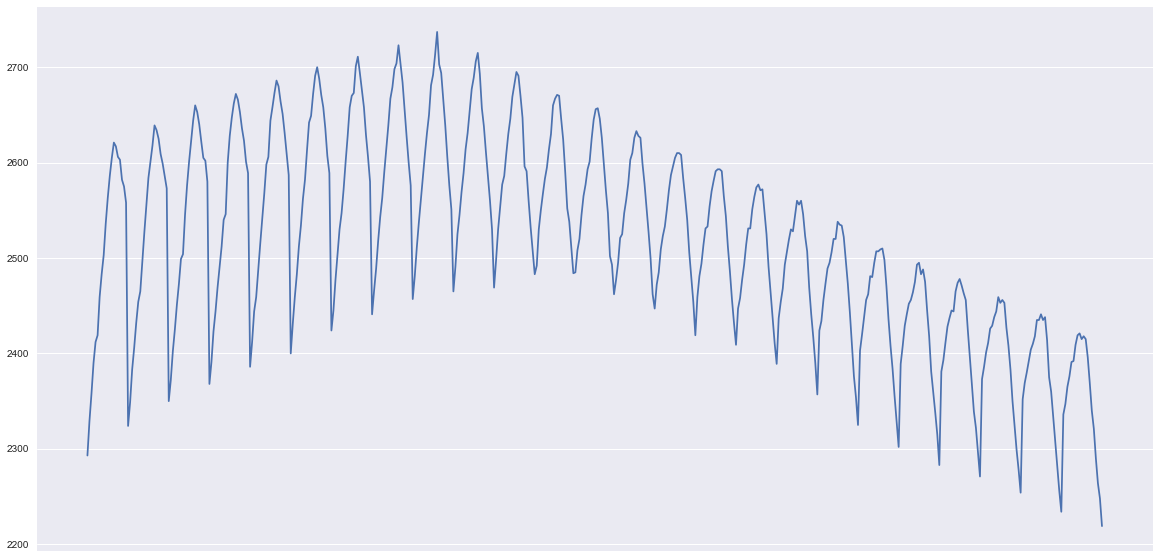

In [41]:
y = list(a.values())
x = list(a.keys())
plt.figure(figsize=(20,10))
plt.xticks(y, x)
plt.plot(y)
plt.show()

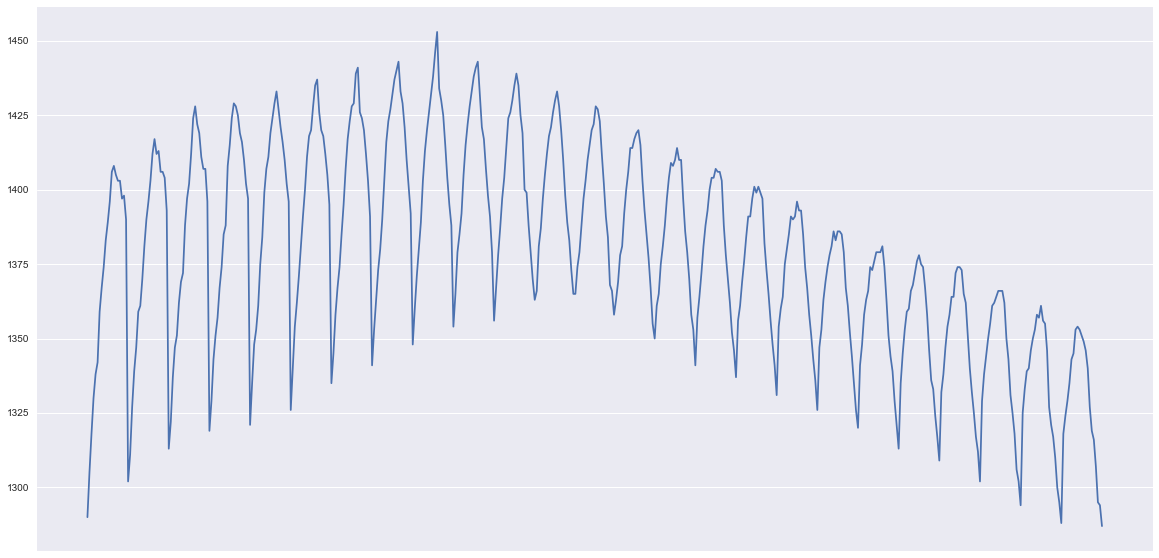

In [42]:
y = list(c.values())
x = list(c.keys())
plt.figure(figsize=(20,10))
plt.xticks(y, x)
plt.plot(y)
plt.show()
#fig.savefig("shift_mnth.png")

In [ ]:
#######below created different format of final dataset

# ungrouped_spire merge

In [ ]:
spire_event = pd.read_csv("spire_eventV3.csv")

In [ ]:
mg_data = pd.concat([finnal_data.iloc[:,1:24],finnal_data.iloc[:,135:144]],axis = 1)
spire_data = spire_event.iloc[:,6:]
spire_data.head(1)

In [ ]:
mgdata = finnal_data.merge(spire_event,on = "event")
mgdata.to_csv("ungrouped_spire.csv")

# Binary format

In [ ]:
new_data = pd.read_csv("JY_Final_Spire.csv")

In [ ]:
new_data.head(1)

In [ ]:
Beverage_name = ["Pepsi","Tropicana Lemonade","Water","Sobe Yumberry Pomegranate","Aquafina Sparkling","Tropicana Pink Lemonade","Diet Pepsi","Diet Sierra Mist","Brisk Raspberry Iced Tea","Sierra Mist","Mountain Dew","Rug Root Beer","Sweet Tea","Diet","LMN","CHR","STW","VAN"]
new_data['drink2'] = new_data['drink2'].fillna("no")
new_data['drink3'] = new_data['drink3'].fillna("no")

In [ ]:
for drink in Beverage_name:
    new_data[drink] = 0
    new_data.loc[new_data['drink1'].str.contains(drink), drink] = 1
    new_data.loc[new_data['drink2'].str.contains(drink), drink] = 1
    new_data.loc[new_data['drink3'].str.contains(drink), drink] = 1

In [ ]:
new_data["flavor"] = new_data["LMN"]+new_data["CHR"]+new_data["STW"]+new_data["VAN"]
new_data["flavor"] = new_data["flavor"].map(lambda x: 1 if x >0 else 0)

In [ ]:
new_data.head(1)

In [ ]:
new_data.to_csv("New_data.csv")